# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Problem Definition:
The goal is to determine which features correlate more to user car prices. To achieve this, we will build a used car price prediction model and evaluate each feature afterwards, using permutation importance.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
import numpy as np
import plotly.express as px
import pandas as pd
import warnings
import matplotlib.pyplot as plt

In [8]:
# reading data into dataframe
df = pd.read_csv('data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [9]:
# checking head
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [10]:
# checking for null values
df.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [12]:
# dropping columns
drop_cols = ['id', 'region', 'model', 'VIN', 'state']
df = df.drop(drop_cols, axis=1)

In [13]:
# ordinal -> condition, 
# onehot -> manufacturer, fuel, title_status, drive, size, type, paint_color

In [14]:
# dropping null rows
df = df.dropna()

In [15]:
# removing 'other' values
df = df.drop(df[df['cylinders'] == 'other'].index)
df = df.drop(df[df['fuel'] == 'other'].index)
df = df.drop(df[df['transmission'] == 'other'].index)
df = df.drop(df[df['type'] == 'other'].index)
df = df.drop(df[df['paint_color'] == 'custom'].index)

In [16]:
# turning cylinder and transmission columns into ints
df = df.replace({'6 cylinders': 6, '4 cylinders': 4, '8 cylinders': 8, '5 cylinders': 5, '10 cylinders': 10, '3 cylinders': 3, '12 cylinders': 12})
df = df.replace({'automatic': 1, 'manual': 0})

In [17]:
# removing values with low value counts and outlier values, also renaming transmission to automatic
man_list = ['alfa-romeo', 'harley-davidson', 'datsun', 'ferrari', 'land rover', 'aston-martin', 'tesla']
color_list = ['yellow', 'purple', 'orange']
df = df[~df['manufacturer'].isin(man_list)]
df = df[~df['paint_color'].isin(color_list)]
df = df[df['fuel'] != 'electric']
df = df[df['title_status'] != 'missing']
df = df[df['title_status'] != 'parts only']
df = df[df['type'] != 'bus']
df = df[df['condition'] != 'salvage']
df = df[df['price'] > 0]
df = df.rename(columns={"transmission": "automatic"})

In [18]:
# new dataframe structure after data preparation
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71209 entries, 31 to 426833
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         71209 non-null  int64  
 1   year          71209 non-null  float64
 2   manufacturer  71209 non-null  object 
 3   condition     71209 non-null  object 
 4   cylinders     71209 non-null  int64  
 5   fuel          71209 non-null  object 
 6   odometer      71209 non-null  float64
 7   title_status  71209 non-null  object 
 8   automatic     71209 non-null  int64  
 9   drive         71209 non-null  object 
 10  size          71209 non-null  object 
 11  type          71209 non-null  object 
 12  paint_color   71209 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 7.6+ MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [20]:
# setting up X and y
X = df.drop('price', axis=1)
y = np.log(df['price'])

In [21]:
# setting up train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
# setting up pipeline and fitting the training data
pipe = Pipeline([
    ('transform', make_column_transformer(
        (OrdinalEncoder(categories = [['fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
        (OneHotEncoder(), ['manufacturer', 'fuel', 'title_status', 'drive', 'size', 'type', 'paint_color']),
        (PolynomialFeatures(degree=3, include_bias=False), ['year', 'cylinders', 'odometer', 'automatic'])),
    ), ('scaler', StandardScaler()), ('ridge', Ridge())
])

pipe.fit(X_train, y_train)

# setting up param dict for gridsearch
param_dict = {'ridge__alpha': [10**a for a in range(-3, 4)]}

# running gridsearch to look for optimal alpha value
cv = GridSearchCV(pipe, param_grid=param_dict, cv=10, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['fair',
                                                                                                     'good',
                                                                                                     'excellent',
                                                                                                     'like '
                                                                                                     'new',
                                                                                                     'new']]),
                                                                         ['condition']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['manufacturer',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color']),
                                                                        ('polynomialfeatures',
                                                                         PolynomialFeatures(degree=3,
                                                                                            include_bias=False),
                                                                         ['year',
                                                                          'cylinders',
                                                                          'odometer',
                                                                          'automatic'])])),
                                       ('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [23]:
# best model
cv.best_estimator_

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'fuel',
                                                   'title_status', 'drive',
                                                   'size', 'type',
                                                   'paint_color']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['year', 'cylinders',
                                                   'odometer',
                                                   'automatic'])])),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.001))])

In [24]:
# getting train set mse
mean_squared_error(cv.predict(X_train), y_train)

0.8673941417305112

In [25]:
# getting test set mse
mean_squared_error(cv.predict(X_test), y_test)

0.916545775294428

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [27]:
# getting permutation importance from gridsearch object
result = permutation_importance(cv, X_train, y_train, n_repeats=10)

In [28]:
result.importances_mean

array([0.35355655, 0.03362056, 0.02527818, 0.13007078, 0.04399836,
       0.07848051, 0.00173097, 0.0109727 , 0.02842883, 0.01365962,
       0.1142304 , 0.002103  ])

Text(0.5, 1.0, 'Permutation Importance Means - Ridge')

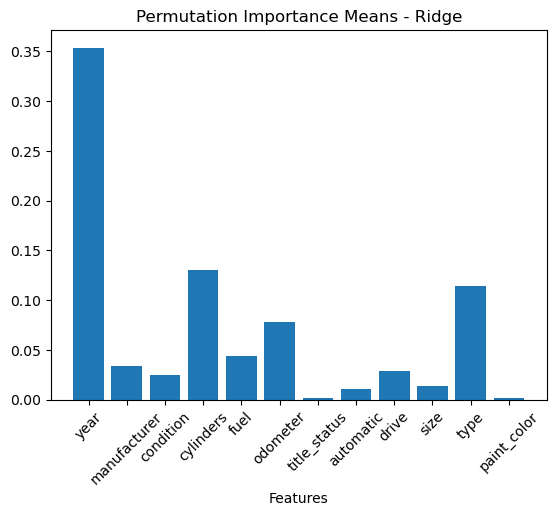

In [29]:
# plotting permutation importance means for each feature
columns = ['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'automatic' ,'drive', 'size', 'type','paint_color']
plt.bar(columns, result.importances_mean)
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.title('Permutation Importance Means - Ridge')

In [30]:
# getting best estimator's coefficients
coefs = cv.best_estimator_.named_steps['ridge'].coef_
coef_df = pd.DataFrame({'name': pipe[:-1].get_feature_names_out(),'coef': coefs})
coef_df = coef_df.sort_values(by='coef', ascending=True)

In [31]:
# checking for features that affect the price most in a negative way
coef_df.head(10)

,name,coef
86,polynomialfeatures__year cylinders^2,-188.429898
69,polynomialfeatures__cylinders,-90.756728
72,polynomialfeatures__year^2,-77.828192
77,polynomialfeatures__cylinders odometer,-26.079894
88,polynomialfeatures__year cylinders automatic,-24.957381
74,polynomialfeatures__year odometer,-16.167353
89,polynomialfeatures__year odometer^2,-7.255397
75,polynomialfeatures__year automatic,-6.941294
91,polynomialfeatures__year automatic^2,-6.941293
92,polynomialfeatures__cylinders^3,-4.040877


In [32]:
# checking for features that affect the price most in a positive way
coef_df.tail(10)

,name,coef
79,polynomialfeatures__odometer^2,8.987027
78,polynomialfeatures__cylinders automatic,12.029246
97,polynomialfeatures__cylinders automatic^2,12.029977
70,polynomialfeatures__odometer,19.691410
85,polynomialfeatures__year^2 automatic,19.775761
87,polynomialfeatures__year cylinders odometer,23.346629
68,polynomialfeatures__year,24.564502
82,polynomialfeatures__year^3,52.186194
83,polynomialfeatures__year^2 cylinders,86.433706
76,polynomialfeatures__cylinders^2,195.169730


In [33]:
# checking gridsearch results
cv.cv_results_

{'mean_fit_time': array([0.20208342, 0.18957195, 0.19647808, 0.20358462, 0.18416708,
        0.18006408, 0.17215655]),
 'std_fit_time': array([0.01432713, 0.01005095, 0.01318816, 0.01292114, 0.00678848,
        0.01289943, 0.00832653]),
 'mean_score_time': array([0.0152138 , 0.01601524, 0.01501381, 0.01541405, 0.01441317,
        0.01341166, 0.01351194]),
 'std_score_time': array([0.00160109, 0.00195124, 0.00189909, 0.002156  , 0.00162602,
        0.00168688, 0.00143263]),
 'param_ridge__alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ridge__alpha': 0.001},
  {'ridge__alpha': 0.01},
  {'ridge__alpha': 0.1},
  {'ridge__alpha': 1},
  {'ridge__alpha': 10},
  {'ridge__alpha': 100},
  {'ridge__alpha': 1000}],
 'split0_test_score': array([-0.8279804 , -0.83224539, -0.83491682, -0.83984341, -0.87210506,
        -0.90454665, -0.9227506 ]),
 'sp

Text(0.5, 1.0, 'Alpha Values vs. MSE')

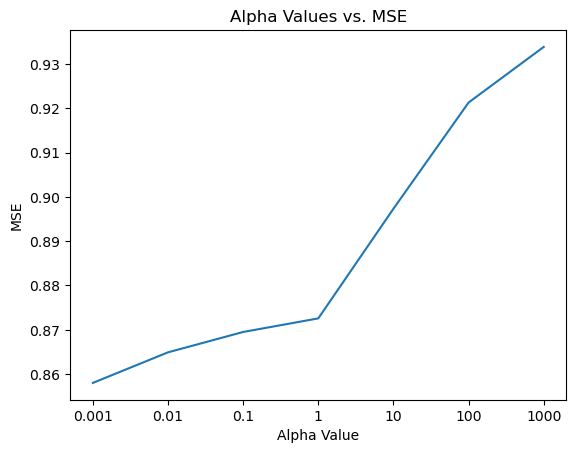

In [34]:
# plotting MSEs for each alpha value
mses = [0.85801179, 0.86491276, 0.86951045, 0.87257613, 0.89732286,
        0.92129563, 0.93384664]
labels = ['0.001', '0.01', '0.1', '1', '10', '100', '1000']

plt.plot(labels, mses)
plt.ylabel('MSE')
plt.xlabel('Alpha Value')
plt.title('Alpha Values vs. MSE')

In [35]:
# setting up second pipeline and fitting the training data
pipe2 = Pipeline([
    ('transform', make_column_transformer(
        (OrdinalEncoder(categories = [['fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
        (OneHotEncoder(), ['manufacturer', 'fuel', 'title_status', 'drive', 'size', 'type', 'paint_color']),
        (PolynomialFeatures(degree=3, include_bias=False), ['year', 'cylinders', 'odometer', 'automatic'])),
    ), ('scaler', StandardScaler()), ('linreg', LinearRegression())
])

pipe2.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'fuel',
                                                   'title_status', 'drive',
                                                   'size', 'type',
                                                   'paint_color']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['year', 'cylinders',
                                                   'odometer',
                                                   'automatic'])])),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [36]:
# calculating the second model's mse on the training set
mean_squared_error(pipe2.predict(X_train), y_train)

0.8580621508074863

In [37]:
# calculating the second model's mse on the test set
mean_squared_error(pipe2.predict(X_test), y_test)

0.9137945910058819

In [38]:
# getting second model's permutation importance
result2 = permutation_importance(pipe2, X_train, y_train, n_repeats=10)

In [39]:
result2.importances_mean

array([0.28047434, 0.02512013, 0.01687058, 0.08340197, 0.03155265,
       0.04154532, 0.00110384, 0.00612179, 0.01877908, 0.00880078,
       0.07852728, 0.0014877 ])

Text(0.5, 1.0, 'Permutation Importance Means - LinReg')

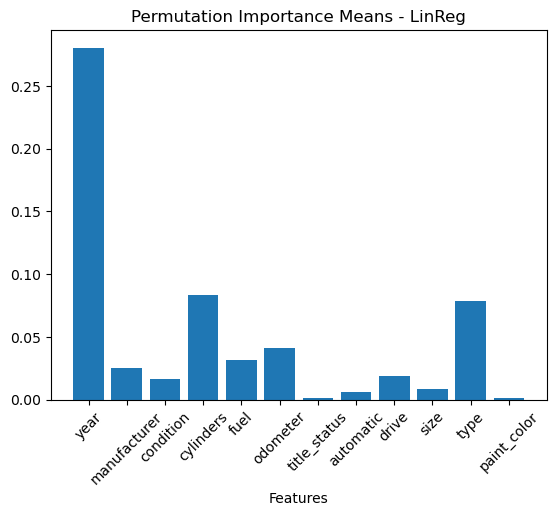

In [40]:
# plotting permutation importance means for linreg model
columns = ['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'automatic' ,'drive', 'size', 'type','paint_color']
plt.bar(columns, result2.importances_mean)
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.title('Permutation Importance Means - LinReg')

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

After training two different models to predict car pricing, these were the permutation importance values for each feature. Permutation importance measures the contribution of each feature to a model's performance. 

![](images/perm_imp.png)

As we can see in this bar plot, the year in which the car was manufactured is the most important feature when it comes to determining its price. This is followed by the number of cylinders, the number of miles it has in its odometer, and the car's type.

Now when it comes to seeing what specific combination of features affect the price negatively and positively, we can look at this data extracted from the same models:

![](images/coefs.png)

In this case, the largest positive and negative factors for price prediction are a combination of the year value and the number of cylinders. Thus, these are the most important features to take into account when determining the price for a used car.